In [1]:
library(tidyverse)
library(progress)
library(nout)

source("../R/utils_data.R")
source("../R/utils_experiments.R")
source("../R/utils_g.R")

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Demo

## Generate scores and plot them

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


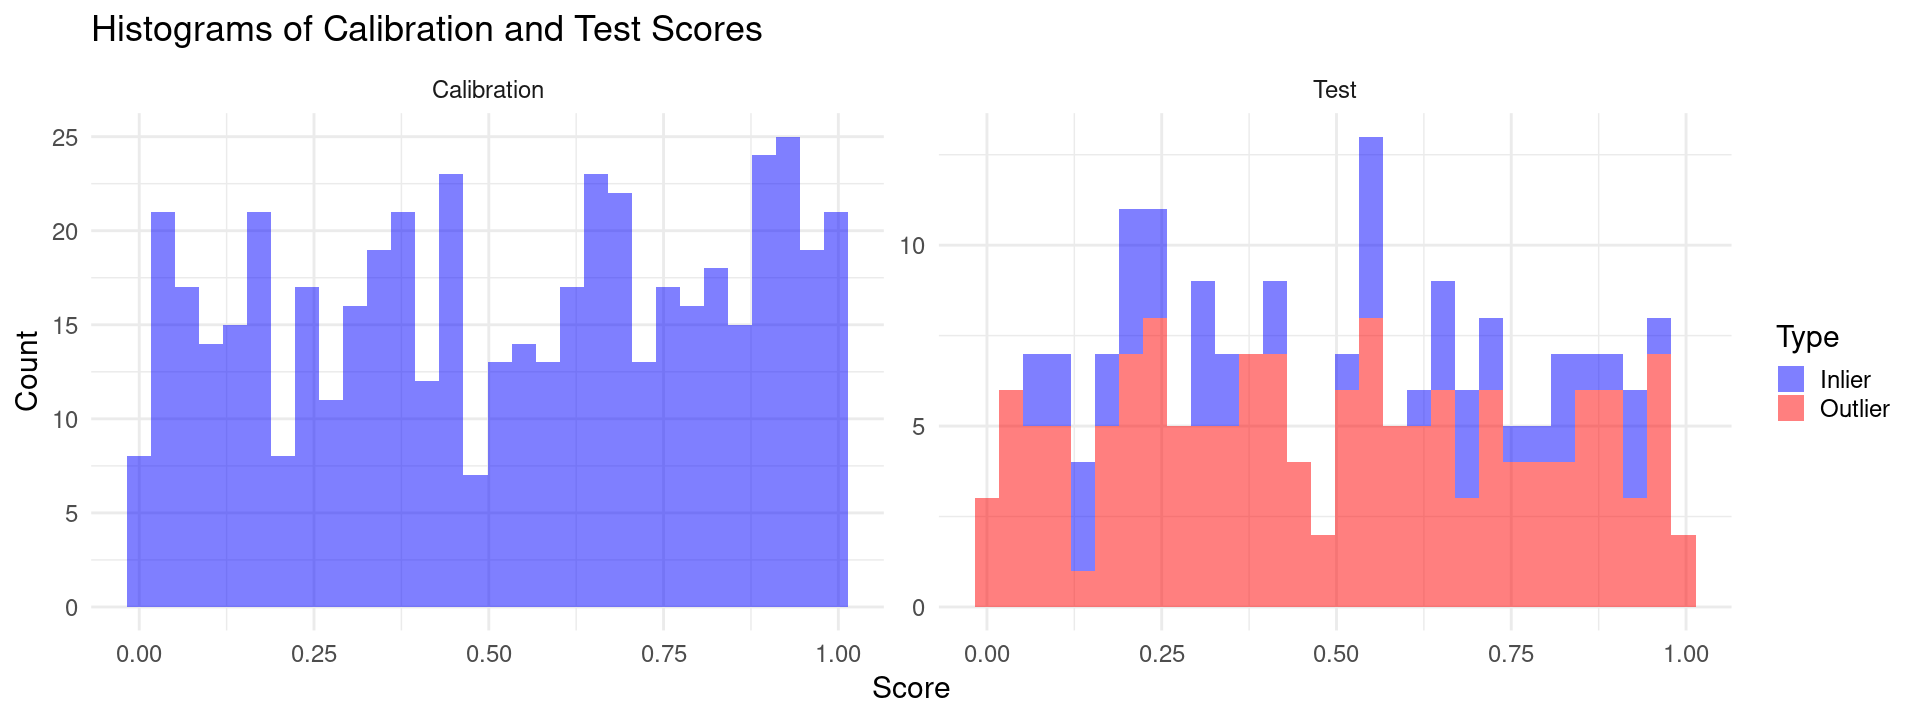

In [2]:
#set.seed(123) # For reproducibility

# Choose alternative distribution
alternative <- "uniform"     #
#alternative <- "lehmann_k3"  #
#alternative <- "beta_0.25_0.25"     #
#alternative <- "beta_4_4"     #
#alternative <- "normal_-0.5_0.2"
#alternative <- "normal_0_1.5"

# Generate a calibration set of inliers from a uniform distribution 
# and a test set containing a mixture of inliers and outliers from a different distribution.
data <- generate_cal_test_scores(n_cal = 500, n_test = 200, prop_out = 0.75, alternative = alternative)

# Prepare the data for plotting with an additional column for inliers/outliers
calibration_df <- tibble(score = data$scores.cal, set = "Calibration", type = "Inlier")
test_df <- tibble(score = data$scores.test, set = "Test", type = ifelse(data$outlier.test == 1, "Outlier", "Inlier"))
plot_data <- bind_rows(calibration_df, test_df)

# Adjust plot size
options(repr.plot.width = 16, repr.plot.height = 6)

# Create side-by-side histograms
ggplot(plot_data, aes(x = score, fill = type)) +
  geom_histogram(alpha = 0.5) +
  facet_wrap(. ~ set, scales = "free_y") +
  theme_minimal(base_size = 18) +  # Increase base font size
  labs(title = "Histograms of Calibration and Test Scores",
       x = "Score",
       y = "Count",
       fill = "Type") +
  scale_fill_manual(values = c("Inlier" = "blue", "Outlier" = "red"))

density_oracle <- function(x) density_scores(x, alternative)

## Monotone oracle density

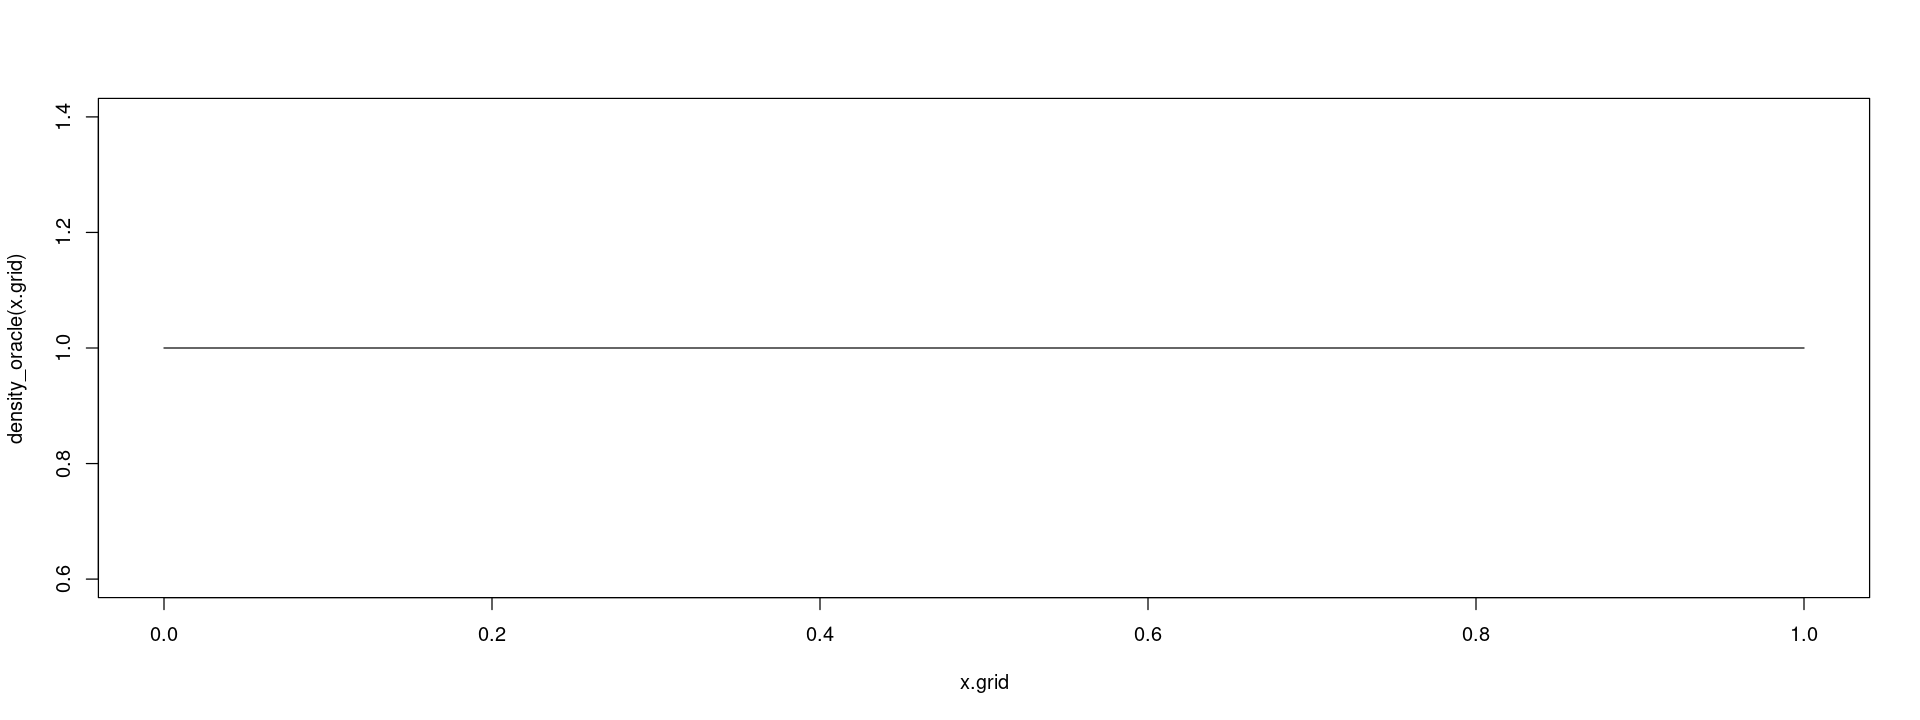

In [3]:
x.grid <- seq(0,1,length.out=1000)

plot(x.grid, density_oracle(x.grid), "l")

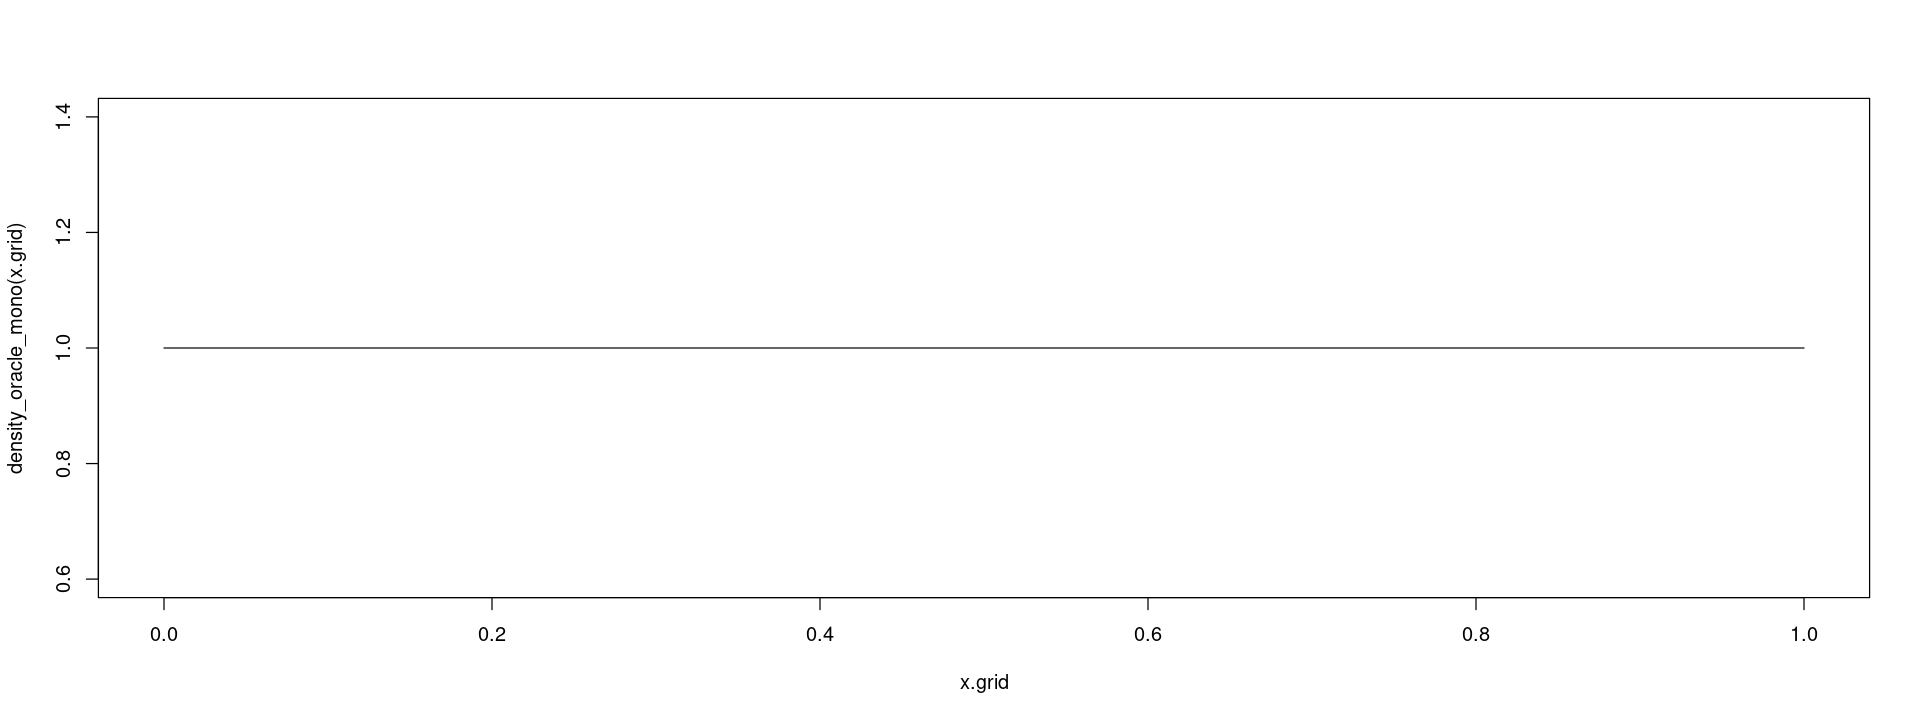

In [4]:
## Function to make density function monotone
make_density_monotone <- function(g) {
  tol = 1e-3
  x.grid <- seq(tol,1-tol,length.out=1000)
    
  ## Obtain density estimates from the model
  g.hat.values <- list(x=x.grid, y=g(x.grid))
  
  ## Create a monotone interpolation function
  iso_fit <- isoreg(g.hat.values$x, g.hat.values$y)
  g.hat.u <- approxfun(iso_fit$x, iso_fit$yf, method = "linear", rule = 2)
  
  ## Normalize the density
  integral <- integrate(g.hat.u, 0, 1)$value
  g.mon <- function(x) g.hat.u(x) / integral
  
  return(g.mon)
}

density_oracle_mono <- make_density_monotone(density_oracle)
plot(x.grid, density_oracle_mono(x.grid), "l")

## Estimate the number of outliers

In [5]:
S_X = data$scores.cal
S_Y = data$scores.test

In [6]:
compute.global.pvalue.shirashi(S_X, S_Y, density_oracle, num_mc=1000)

[1] 0.9154451

In [7]:
d_selection_G2(S_X, S_Y, g.oracle=density_oracle_mono, monotonicity="increasing", alpha=0.1, n_perm=0, B=10^3, B_MC=10^3, seed=123)

$lower.bound
[1] 0

$global.pvalue
[1] 0.901525

$S
NULL

$selection.p.value
[1] 1

In [8]:
d_selection_G2(S_X, S_Y, g.oracle=density_oracle, monotonicity=NULL, alpha=0.1, n_perm=0, B=10^3, B_MC=10^3, seed=123)

$lower.bound
[1] 0

$global.pvalue
[1] 0.2416321

$S
NULL

$selection.p.value
[1] 1

In [9]:
d_selection_G2(S_X, S_Y, g.oracle=NULL, fit.method="betamix", monotonicity="increasing", alpha=0.1, n_perm=0, B=10^3, B_MC=10^3, seed=123)

$lower.bound
[1] 0

$global.pvalue
[1] 0.5861642

$S
NULL

$selection.p.value
[1] 1

In [10]:
d_selection_G2(S_X, S_Y, g.oracle=density_oracle, monotonicity="increasing", alpha=0.1, n_perm=0, B=10^3, B_MC=10^3, seed=123)

$lower.bound
[1] 0

$global.pvalue
[1] 0.2021463

$S
NULL

$selection.p.value
[1] 1

In [ ]:
source("../R/utils_experiments.R")
run_outlier_enumeration(data, alpha=0.1, alternative=alternative)